In [1]:
import pandas as pd
import numpy as np
import sklearn
import os
import keras 

#versions
print(pd.__version__)
print(np.__version__)
print(sklearn.__version__)
print(keras.__version__)

Using TensorFlow backend.


0.22.0
1.14.2
0.19.1
2.2.4


In [2]:

train_file_load = pd.read_csv(r'D:\Machine Learning\kuc-hackathon-winter-2018\drugsComTrain_raw.csv')
test_file_load = pd.read_csv(r'D:\Machine Learning\kuc-hackathon-winter-2018\drugsComTest_raw.csv')

train_file= pd.DataFrame(train_file_load)
test_file = pd.DataFrame(test_file_load)

# First 5 Rows of training data:
print(train_file.head())
print('\n')

# Training and Testing data Shapes:
print('Training Data Shape:',train_file.shape)
print('Test Data Shape:',test_file.shape)

###We have 7 columns:

#uniqueID    -Unique ID
#drugName    -Name of drug
#condition   -Name of condition
#review      -Patient review
#rating      -10 star patient rating
#date        -Date of review entry
#usefulCount -Number of users who found review useful

   uniqueID                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...       9  20-May-12   
1  "My son is halfway through his fourth week of ...       8  27-Apr-10   
2  "I used to take another oral contraceptive, wh...       5  14-Dec-09   
3  "This is my first time using any form of birth...       8   3-Nov-15   
4  "Suboxone has completely turned my life around...       9  27-Nov-16   

   usefulCount  
0           27  
1          192  
2           17  
3           10  
4           37  


Training Data Shap

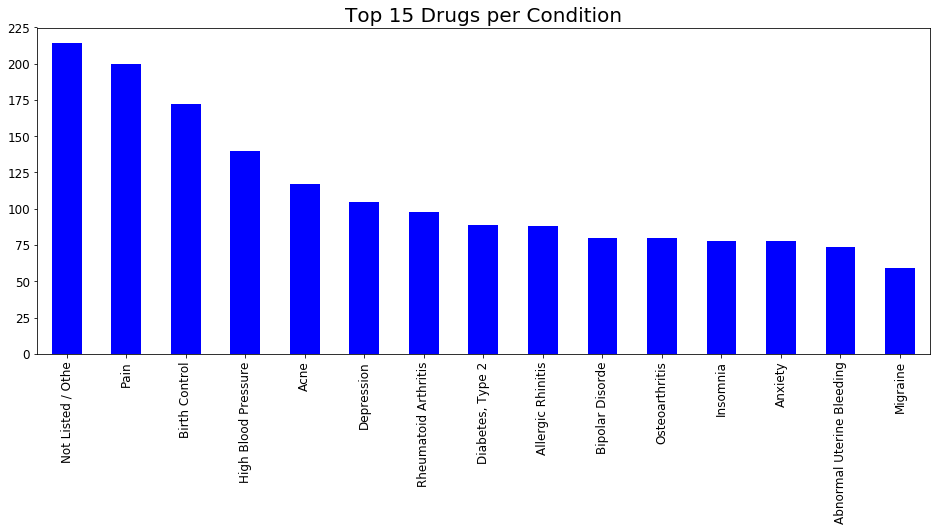

In [3]:
### Data Exploration ###

import matplotlib.pyplot as plt

# This graph shows the type of conditions being represented in the reviews:
condition = train_file.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition[0:15].plot(kind="bar", figsize = (16,6), fontsize = 12, color = 'blue')
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top 15 Drugs per Condition", fontsize = 20)
plt.show()



In [4]:
### Average Rating per most common Medication reviewed:
mean_rating = train_file.groupby(['drugName'])['rating'].agg(['count', 'mean']).sort_values(by=['count', 'mean'], ascending=False)[:15]
print(mean_rating)


                                    count      mean
drugName                                           
Levonorgestrel                       3657  7.391031
Etonogestrel                         3336  5.802458
Ethinyl estradiol / norethindrone    2850  5.591930
Nexplanon                            2156  5.673006
Ethinyl estradiol / norgestimate     2117  5.856873
Ethinyl estradiol / levonorgestrel   1888  5.799258
Phentermine                          1543  8.786131
Sertraline                           1360  7.497794
Escitalopram                         1292  7.843653
Mirena                               1242  6.587762
Implanon                             1102  6.078040
Gabapentin                           1047  7.438395
Bupropion                            1022  7.445205
Venlafaxine                          1016  6.800197
Miconazole                           1000  3.033000


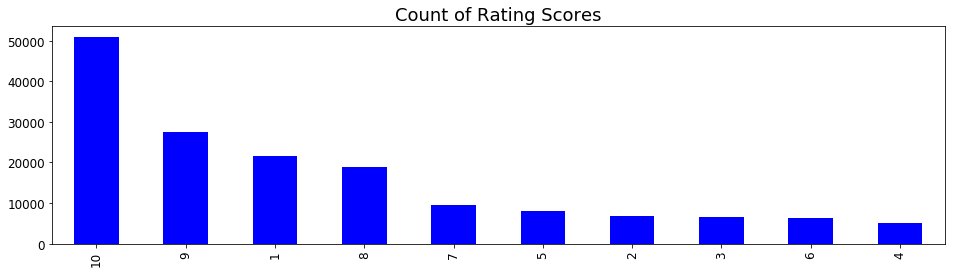

In [5]:
### Distribution of Ratings ###
# Here we see people are most likely to give a review if they were satisfied with the medication or if they strongly disliked
# the medication.

review_rating = train_file['rating'].value_counts().sort_values(ascending=False)
review_rating.plot(kind="bar", figsize = (16,4), fontsize = 12, color = 'blue')
plt.xlabel("", fontsize = 18)
plt.ylabel("", fontsize = 18)
plt.title("Count of Rating Scores", fontsize = 18)
plt.show()


In [6]:

# Deleting missing values:
train_file = train_file.dropna(axis=0)
test_file = test_file.dropna(axis=0)

# New data shapes once missing values removed:
print('New Training Data Shape:',train_file.shape)
print('New Test Data Shape:',test_file.shape)


# Changing the data from 10 categories to 2. A rating of 5 and below is classified as "0",
# a rating of 6 and up is classifed as "1":

train_file['rating'] = np.where(train_file['rating'].between(0,5), 0, train_file['rating'])
train_file['rating'] = np.where(train_file['rating'].between(6,10), 1, train_file['rating'])


test_file['rating'] = np.where(test_file['rating'].between(0,5), 0, test_file['rating'])
test_file['rating'] = np.where(test_file['rating'].between(6,10), 1, test_file['rating'])


# Checking to see if conversion worked by looking at first 5 rows of data:
print(train_file['rating'].head(5))
print(test_file['rating'].head(5))


New Training Data Shape: (160398, 7)
New Test Data Shape: (53471, 7)
0    1
1    1
2    0
3    1
4    1
Name: rating, dtype: int64
0    1
1    1
2    1
3    1
4    1
Name: rating, dtype: int64


In [7]:

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence

# Examples of three reviews:
print(train_file['review'][:3])


# cuts off reviews after 300 words - this will only be used for padding:
maxlen = 300

# Considers only the top 5000 words in the reviews:
maxwords = 5000

# Creates a Tokenizer that only takes into acccount the top 5000 words:
tokenizer = Tokenizer(num_words=maxwords)


# This builds the Word Index (as a dictionary)
# The Tokenizer will represent each word as a unique integer, which is necessary for embedding layer in the neural network.
tokenizer.fit_on_texts(train_file['review'])
tokenizer.fit_on_texts(test_file['review'])

# This turns strings into lists of integer indices
sequences = tokenizer.texts_to_sequences(train_file['review'])
sequences_test = tokenizer.texts_to_sequences(test_file['review'])


one_hot_results = tokenizer.texts_to_matrix(train_file['review'], mode='binary')
one_hot_results_test = tokenizer.texts_to_matrix(test_file['review'], mode='binary')

# Creates a dictionary of embeddings:
word_index = tokenizer.word_index
print(len(word_index))

print(one_hot_results[:3])
print(one_hot_results_test[:3])


0    "It has no side effect, I take it in combinati...
1    "My son is halfway through his fourth week of ...
2    "I used to take another oral contraceptive, wh...
Name: review, dtype: object
55231
[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]
[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [8]:
### PADDING THE REVIEWS ###

# This will pad the reviews that are fewer than 300 words with zeros:
padded_data = pad_sequences(sequences, maxlen = maxlen)
padded_data_test = pad_sequences(sequences_test, maxlen = maxlen)

print(padded_data.shape)

# shape of 160398,300 indicates that all reviews were tokenized because shape after removal of missing values is 160398

(160398, 300)


In [9]:
# Using Pre-trained GloVe Word embeddings

glove_directory = r'D:\Machine Learning\GLoVE Word Embeddings'

# create empty dictionary you can append embeddings to
embeddings_index = {}

f = open(os.path.join(glove_directory,'glove.6B.100d.txt'),encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors'% len(embeddings_index))

Found 400000 word vectors


In [10]:
# preparing word embeddings matrix

# this will find 100 words that are associated with that particular vector/word:
embedding_dim = 100
embedding_matrix = np.zeros((maxwords, embedding_dim))
for word, i in word_index.items():
    if i < maxwords:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i]= embedding_vector
            


In [11]:
### CALLBACKS ###

from keras import callbacks


filepath=str(os.getcwd()+"/best medication sentiment model1.h5f")

# ReduceLROnPlateau - will reduce the learning rate by a factor of 0.2 when the validation loss doesn't decrease after 2 epochs.
#                     cooldown means that the model will run two epochs at the reduced learning rate before going back to 
#                     original learning rate.
# Model Checkpoint - saves the best model
callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor = 0.2,
                                                     patience = 2,
                                                      cooldown=2),
                    keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                     monitor='val_acc',
                                                    verbose=1,
                                                     save_best_only=True,
                                                    mode='max')]


In [12]:
### BUILDING THE NEURAL NETWORK ARCHITECTURE ###

from keras import layers, optimizers, models
from keras.layers import Input, Flatten, Embedding, Dense, LSTM, Bidirectional, Dropout
from keras.models import Model, Sequential

### EXPLANATION OF ARCHITECURE: ###
# After trying out a few different architectures for the model, I settled on a Bidirectional LSTM Recurrent layer.
 # For natural language processing tasks, the sequence of the words is important, but which end of the sequence you start from
# may not matter as much. A Bidrectional LSTM model will first analyze the sequence from beginning to end, then once again 
# from the end to the beginning. Going over the data once again, but backwards, can help the model glean more information that 
# would otherwise not be noticed if only looked at from beginning to end. In this situation I found the Bidirectional network
# added a few percentage points to the accuracy of this model. 

# 128 indicates the dimension of the output dense embedding
model = Sequential()
model.add(layers.Embedding(maxwords, 128))
model.add(layers.Bidirectional(layers.LSTM(32, dropout = 0.2, recurrent_dropout = 0.3)))        
model.add(layers.Dense(1, activation='sigmoid'))

# Compiling the model:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary of the model:
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         640000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 681,281
Trainable params: 681,281
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
### TRAINING THE NEURAL NETWORK ###

history = model.fit(padded_data, train_file['rating'],
                  epochs = 10, batch_size = 1000,
                    callbacks=callbacks,
                  validation_data = (padded_data_test, test_file['rating']))
             

Train on 160398 samples, validate on 53471 samples
Epoch 1/10
160398/160398 [==============================] - 3971s 25ms/step - loss: 0.4725 - acc: 0.7795 - val_loss: 0.4055 - val_acc: 0.8205

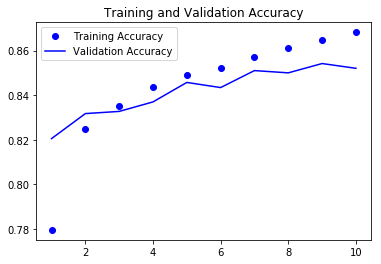

In [14]:
### RESULTS OF TRAINING ###

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs,val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

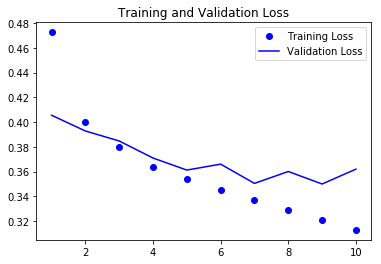

In [15]:
plt.plot(epochs,loss, 'bo', label = 'Training Loss')
plt.plot(epochs,val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [16]:
# We see the model begins to diverge after the 5th epoch for both accuracy and loss 
# which indicates overfitting on the training data.

# Test data plateaus at around 85% Accuracy.

